In [1]:
import menpo.io as mio
from menpo.visualize import print_progress
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68_trimesh

path_to_images = 'trainset2/'
training_images = []
for img in print_progress(mio.import_images(path_to_images, verbose=True)):
    # convert to greyscale
    if img.n_channels == 3:
        img = img.as_greyscale()
    # crop to landmarks bounding box with an extra 20% padding
    img = img.crop_to_landmarks_proportion(0.2)
    # rescale image if its diagonal is bigger than 400 pixels
    d = img.diagonal()
    if d > 400:
        img = img.rescale(400.0 / d)
    # define a TriMesh which will be useful for Piecewise Affine Warp of HolisticAAM
    labeller(img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
    # append to list
    training_images.append(img)
    
%matplotlib inline
from menpowidgets import visualize_images
#visualize_images(training_images)
print(training_images[0])

Found 5 assets, index the returned LazyList to import.
[====================] 100% (5/5) - done.                                       
288W x 278H 2D Image with 1 channel


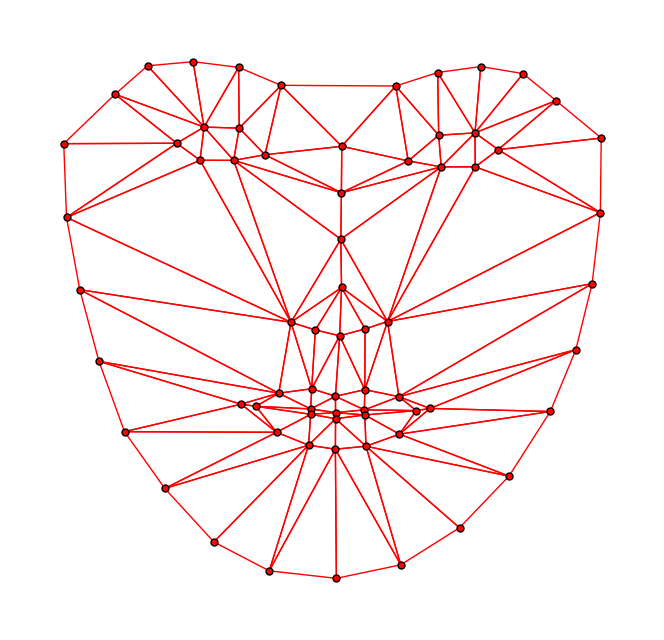

In [2]:
from menpofit.aam import HolisticAAM
from menpo.feature import fast_dsift

aam = HolisticAAM(training_images, group='face_ibug_68_trimesh', diagonal=150,
                  scales=(0.5, 1.0), holistic_features=fast_dsift, verbose=True,
                  max_shape_components=20, max_appearance_components=150)

aam.view_shape_models_widget()

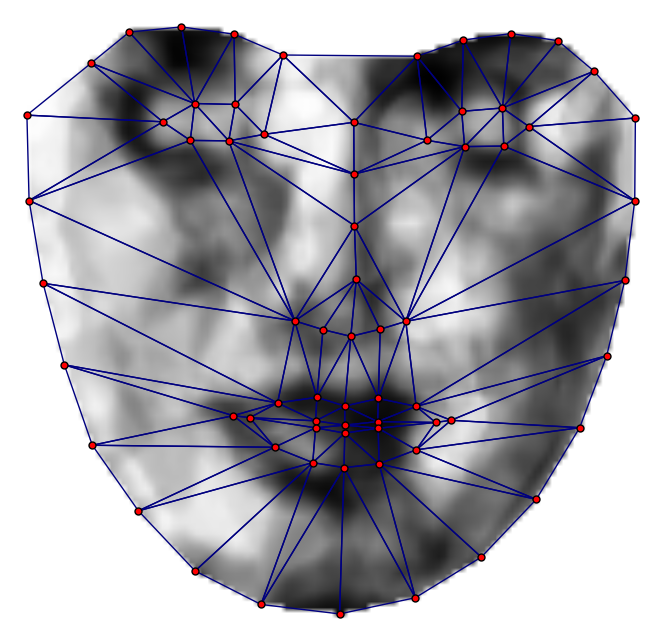

In [3]:
aam.view_appearance_models_widget()

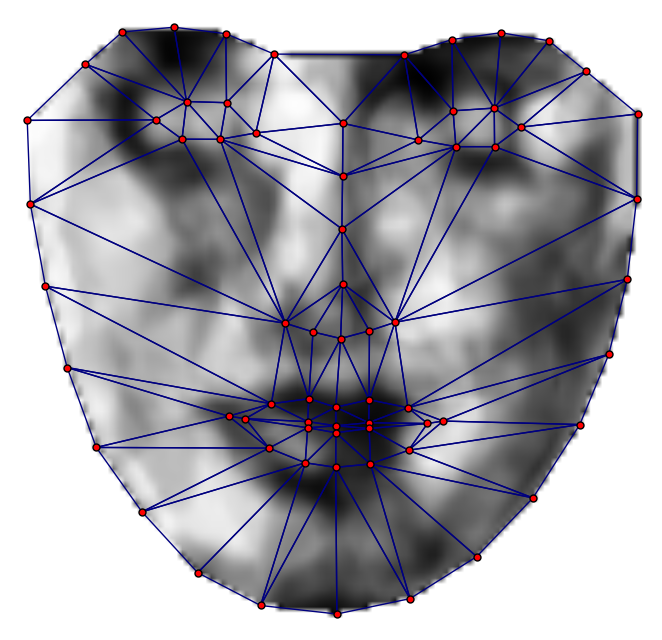

In [4]:
aam.view_aam_widget()


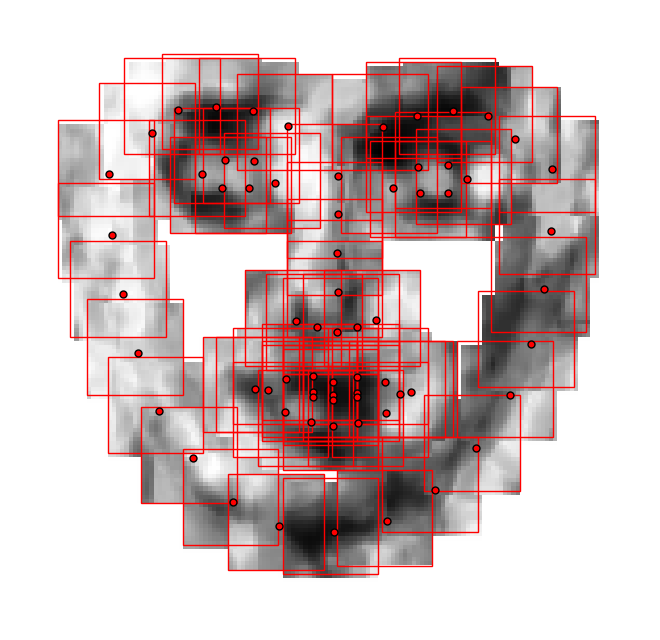

In [5]:
from menpofit.aam import PatchAAM
from menpo.feature import fast_dsift

patch_aam = PatchAAM(training_images, group='PTS', patch_shape=[(15, 15), (23, 23)],
                     diagonal=150, scales=(0.5, 1.0), holistic_features=fast_dsift,
                     max_shape_components=20, max_appearance_components=150,
                     verbose=True)

patch_aam.view_appearance_models_widget()

In [6]:
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional

fitter = LucasKanadeAAMFitter(patch_aam, lk_algorithm_cls=WibergInverseCompositional,
                              n_shape=[5, 20], n_appearance=[30, 150])

print(fitter)

Patch-based Active Appearance Model
 - Images scaled to diagonal: 150.00
 - No image warping performed
 - Scales: [0.5, 1.0]
   - Scale 0.5
     - Holistic feature: dsift
     - Appearance model class: PCAModel
       - 4 appearance components
     - Shape model class: OrthoPDM
       - 4 shape components
       - 4 similarity transform parameters
     - Patch shape: (15, 15)
   - Scale 1.0
     - Holistic feature: dsift
     - Appearance model class: PCAModel
       - 4 appearance components
     - Shape model class: OrthoPDM
       - 4 shape components
       - 4 similarity transform parameters
     - Patch shape: (23, 23)
Wiberg Inverse Compositional Algorithm
 - Scales: [0.5, 1.0]
   - Scale 0.5
     - 4 active shape components
     - 4 similarity transform components
     - 4 active appearance components
   - Scale 1.0
     - 4 active shape components
     - 4 similarity transform components
     - 4 active appearance components
    


In [7]:
from pathlib import Path

import menpo.io as mio

path_to_lfpw = Path('testset/')

image = mio.import_image(path_to_lfpw / 'zzz.jpg')
image = image.as_greyscale()

C:\Users\Chashika Weerathunga\Anaconda3\envs\aamMenpo\lib\site-packages\menpo\image\base.py:2652: MenpoDeprecationWarning: This method is no longer supported and will be removed in a future version of Menpo. Use .pixels_with_channels_at_back instead.
  MenpoDeprecationWarning)


1 detected faces.


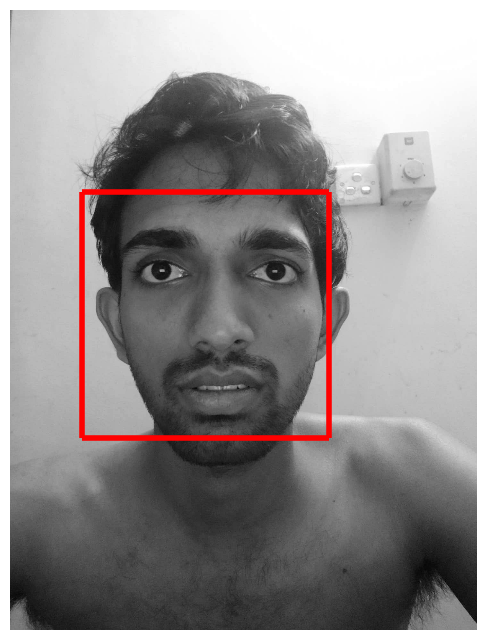

In [8]:
from menpodetect import load_dlib_frontal_face_detector

# Load detector
detect = load_dlib_frontal_face_detector()

# Detect
bboxes = detect(image)
print("{} detected faces.".format(len(bboxes)))

# View
if len(bboxes) > 0:
    image.view_landmarks(group='dlib_0', line_colour='red',
                         render_markers=False, line_width=4);

In [9]:
# initial bbox
initial_bbox = bboxes[0]

# fit image
result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15, 5],
                            gt_shape=image.landmarks['PTS'].lms)

# print result
print(result)

Fitting result of 68 landmark points.
Initial error: 3.8249
Final error: 4.1070


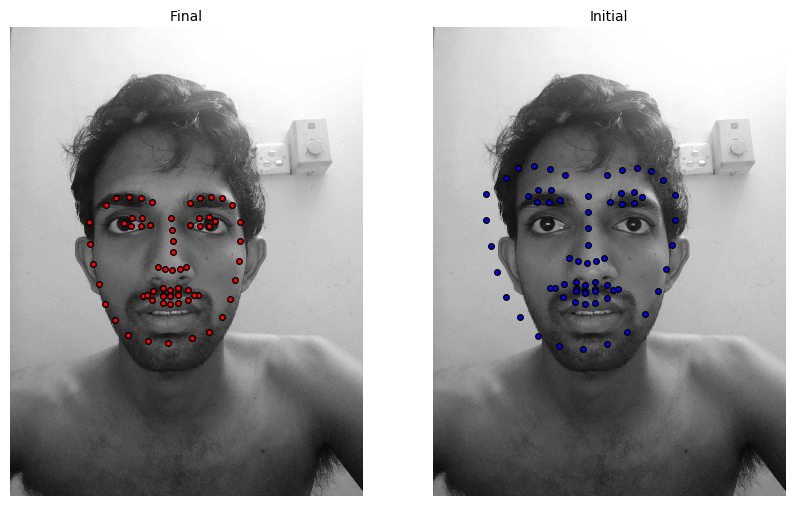

In [10]:
result.view(render_initial_shape=True)

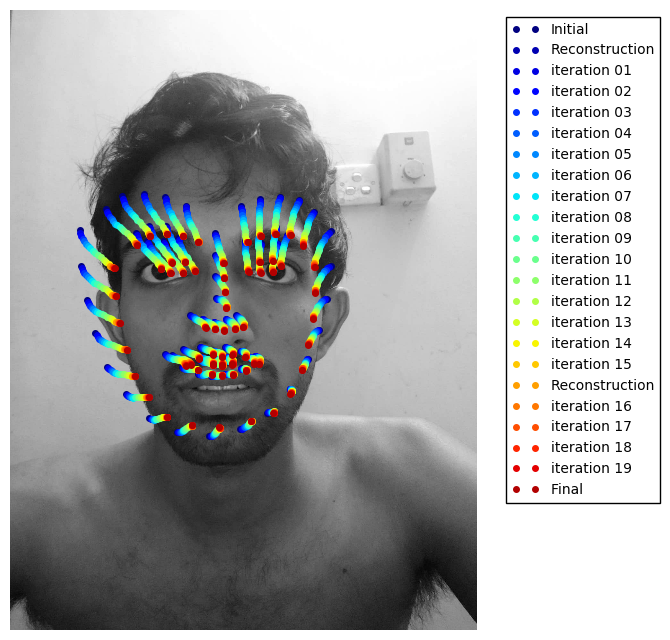

In [11]:
result.view_iterations()


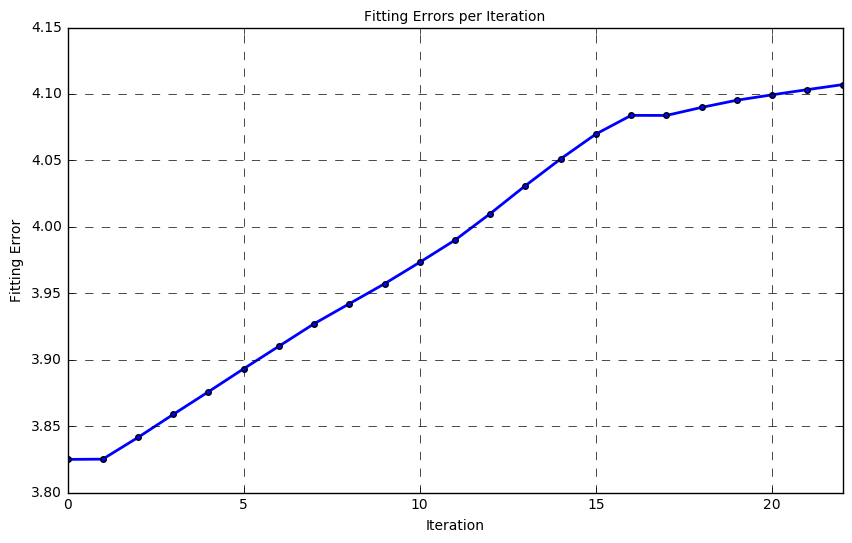

In [12]:
result.plot_errors()

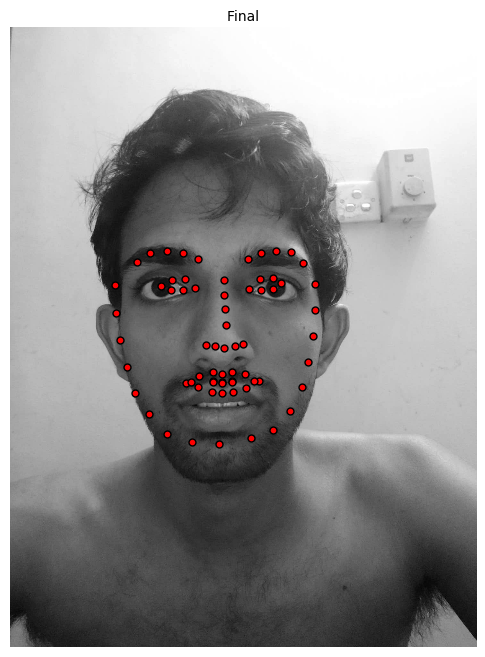

In [13]:
result.view_widget()

C:\Users\Chashika Weerathunga\Anaconda3\envs\aamMenpo\lib\site-packages\menpo\image\base.py:2652: MenpoDeprecationWarning: This method is no longer supported and will be removed in a future version of Menpo. Use .pixels_with_channels_at_back instead.
  MenpoDeprecationWarning)


Fitting result of 68 landmark points.
Initial error: 0.5780
Final error: 0.5726


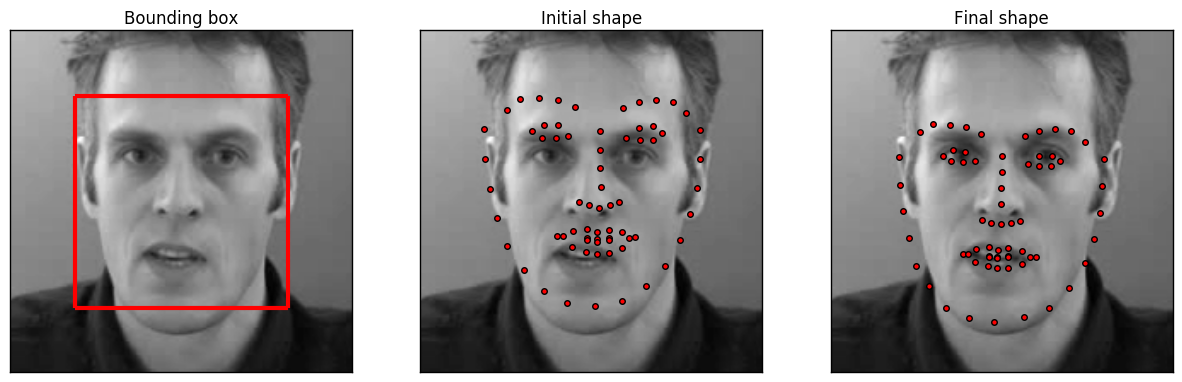

In [14]:
import matplotlib.pyplot as plt

# Load and convert to grayscale
image = mio.import_image(path_to_lfpw / 'scene00001.png')
image = image.as_greyscale()

# Detect face
bboxes = detect(image)

# Crop the image for better visualization of the result
image = image.crop_to_landmarks_proportion(0.3, group='dlib_0')
bboxes[0] = image.landmarks['dlib_0'].lms

if len(bboxes) > 0:
    # Fit AAM
    result = fitter.fit_from_bb(image, bboxes[0], max_iters=[15, 5],
                                gt_shape=image.landmarks['PTS'].lms)
    print(result)

    # Visualize
    plt.subplot(131);
    image.view()
    bboxes[0].view(line_width=3, render_markers=False)
    plt.gca().set_title('Bounding box')

    plt.subplot(132)
    image.view()
    result.initial_shape.view(marker_size=4)
    plt.gca().set_title('Initial shape')

    plt.subplot(133)
    image.view()
    result.final_shape.view(marker_size=4, figure_size=(15, 13))
    plt.gca().set_title('Final shape')

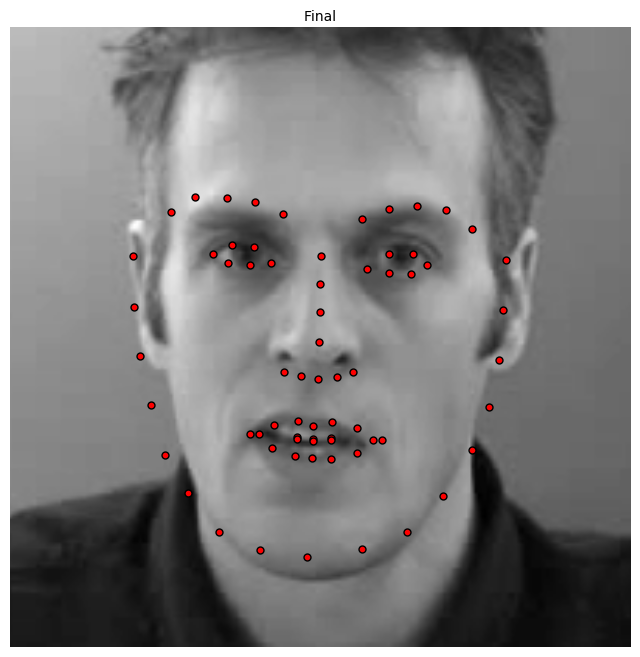

In [15]:
result.view_widget()

In [16]:
result.shapes

In [17]:
print(result.shape_parameters.shape)
#print(result.appearance_parameters.shapes)

AttributeError: 'list' object has no attribute 'shape'